In [1]:
!pip install ujson 
!pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/f8/8c/5274ba7b4df814c87a8840a58e2b1dae6a489f49c3b0fad2d15f1e41d47b/ujson-5.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45 kB)
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/10/5b/0479d7d845b5ba410ca702ffcd7f2cd95a14a4dfff1fde2637802b258b9b/seaborn-0.11.2-py3-none-any.whl (292 kB)
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import sys 
sys.path.append('../')

In [3]:
import os
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
from src import dataset_lvis
from src import metrics
from src import helper_functions as helper
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pandas as pd 
import time 
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [4]:
importlib.reload(dataset_lvis)

<module 'src.dataset_lvis' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/dataset_lvis.py'>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load train and validation data 

In [6]:
time_start = time.time()

data_args = {'stage': 'train',
            'classes': ['cowboy_hat', 'coffee_maker', 'monkey', 'cappuccino', 'drumstick', 'chessboard'], # ['drumstick'],#'sofa'], #, 'signboard'],
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
            'max_negative' : 0}
train_data = dataset_lvis.LVISData(**data_args)

print(f'Time taken to initialize train set: {time.time()-time_start}')

classes : {1: 'cappuccino', 2: 'chessboard', 3: 'coffee_maker', 4: 'cowboy_hat', 5: 'drumstick', 6: 'monkey'}
loaded 618 positive set images
loaded 0 negative set images
loaded 25 non-exhaustive set images
Loaded 593 images!
class 1 has 71 positive and 0 negative images
class 2 has 9 positive and 0 negative images
class 3 has 233 positive and 0 negative images
class 4 has 199 positive and 0 negative images
class 5 has 8 positive and 0 negative images
class 6 has 73 positive and 0 negative images
995 annotations found!
stage:  train
classes:  {'cappuccino': 206, 'chessboard': 240, 'coffee_maker': 284, 'cowboy_hat': 319, 'drumstick': 400, 'monkey': 699}
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_train.json
imgs_dir:  ../Datasets/coco/images/train2017
Time taken to initialize train set: 38.87226915359497


### Split train set into custom train val set

Validation set reserved for testing

Check that we don't have too many of the rare cases in validation set - if so then there won't be much data to actually train on.

In [7]:
# what images have what classes?
g_cpu = torch.Generator()
g_cpu.manual_seed(2)

#Split dataset to test and train
indices = torch.randperm(len(train_data), generator=g_cpu).tolist()


dataset_train = torch.utils.data.Subset(train_data, indices[:550])
dataset_val = torch.utils.data.Subset(train_data, indices[550:])


class_counts = dict(zip(range(1,7), [0]*6))
for _, _, y in dataset_val:
    for label in y['labels']:
        class_counts[label.item()] += 1
            
class_counts

{1: 6, 2: 1, 3: 26, 4: 14, 5: 0, 6: 12}

## Prepare test set

The LVIS validation set is reserved for our test set

In [8]:
time_start = time.time() 
data_args = {'stage': 'val',
            'classes': ['cowboy_hat', 'coffee_maker', 'monkey', 'cappuccino', 'drumstick', 'chessboard'], #['drumstick'],#'sofa'], #, 'signboard'],
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
            'max_negative' : 200}   # note that we include negative sets for the testing
val_data = dataset_lvis.LVISData(**data_args)
print(f'Time taken to initialize val set: {time.time()-time_start}')

classes : {1: 'cappuccino', 2: 'chessboard', 3: 'coffee_maker', 4: 'cowboy_hat', 5: 'drumstick', 6: 'monkey'}
loaded 119 positive set images
loaded 1003 negative set images
loaded 2 non-exhaustive set images
Loaded 1116 images!
class 1 has 17 positive and 189 negative images
class 2 has 1 positive and 186 negative images
class 3 has 46 positive and 172 negative images
class 4 has 39 positive and 188 negative images
class 5 has 2 positive and 111 negative images
class 6 has 12 positive and 182 negative images
166 annotations found!
stage:  val
classes:  {'cappuccino': 206, 'chessboard': 240, 'coffee_maker': 284, 'cowboy_hat': 319, 'drumstick': 400, 'monkey': 699}
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_val.json
imgs_dir:  ../Datasets/coco/images/train2017
Time taken to initialize val set: 4.194173812866211


# Fine-tuning the model

Here we set `pretrained = True` for the FPN: FPN is pre-trained on coco dataset. We keep the backbone ResNet50 pretrained on ImageNet.

In [9]:
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Set up DataLoaders

In [10]:

train_loader = torch.utils.data.DataLoader(
 dataset_train, batch_size=10, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())

val_loader = torch.utils.data.DataLoader(
 dataset_val, batch_size=10, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


# Initialize Model + Model params

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 7 classes - background and 6 specified objects
num_classes = 7

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train Model

In [18]:
num_epochs = 50
time_start = time.time() 


train_loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])
val_loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])

loss_types = ['loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss']


for epoch in range(num_epochs):
    model.train()
    
    train_loss = dict.fromkeys(loss_types, 0) 
    val_loss = dict.fromkeys(loss_types, 0) 
    
    """
    Train 
    """
    for batch_num, (idx, X, y) in enumerate(train_loader):
        #print(idx)
        X = X.to(device)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        
        loss_dict = model(X, y) 
        
        losses = sum(loss for loss in loss_dict.values())
        
        #save losses
        for key in loss_types:
            if key != 'total_loss':
                train_loss[key] += loss_dict[key].item()
            else: 
                train_loss['total_loss'] += losses.item()
                

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    row = pd.DataFrame({'epoch': [epoch],
          'loss_classifier': [train_loss['loss_classifier']/(batch_num+1)],
          'loss_box_reg' : [train_loss['loss_box_reg']/(batch_num+1)],
           'loss_mask': [train_loss['loss_mask']/(batch_num+1)],
           'loss_objectness': [train_loss['loss_objectness']/(batch_num+1)],
           'loss_rpn_box_reg': [train_loss['loss_rpn_box_reg']/(batch_num+1)],
            'total_loss': [train_loss['total_loss']/(batch_num+1)] 
          })     

    train_loss_df = pd.concat([train_loss_df, row], ignore_index = True, axis = 0)
    
    print(f"Training loss after {epoch} epochs: {train_loss['total_loss']}")

    
    """
    Validation
    """
    with torch.no_grad():
        for batch_num, (idx, X, y) in enumerate(val_loader):
            X = X.to(device)
            y = [{k: v.to(device) for k, v in t.items()} for t in y]

            loss_dict = model(X, y) 
            
            losses_val = sum(loss for loss in loss_dict.values())
            
            #save losses
            for key in loss_types:
                if key != 'total_loss':
                    val_loss[key] += loss_dict[key].item()
                else: 
                    val_loss['total_loss'] += losses_val.item()
                    
        row = pd.DataFrame({'epoch': [epoch],
                          'loss_classifier': [val_loss['loss_classifier']/(batch_num+1)],
                          'loss_box_reg' : [val_loss['loss_box_reg']/(batch_num+1)],
                           'loss_mask': [val_loss['loss_mask']/(batch_num+1)],
                           'loss_objectness': [val_loss['loss_objectness']/(batch_num+1)],
                           'loss_rpn_box_reg': [val_loss['loss_rpn_box_reg']/(batch_num+1)],
                            'total_loss': [val_loss['total_loss']/(batch_num+1)] 
                          })
        val_loss_df = pd.concat([val_loss_df, row], ignore_index = True, axis = 0)

    print(f"Validation loss after {epoch} epochs: {val_loss['total_loss']}") 
    print(f'Time elapsed for {epoch} epochs: {time.time()-time_start}') 

      
    """
    Save checkpoints and losses every 5 epoch
    """
    if epoch%5 == 0: 
        checkpoint = {"state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "step": epoch,
                        "ds_args" : data_args
                        }
        fname = "model_" + str(epoch) + "_epochs.pth"
        helper.save_checkpoint(checkpoint, fname)
        print(f'Time elapsed after {epoch} epochs: {time.time()-time_start}')  
        val_loss_df.to_csv(Path.cwd().parent.joinpath("val_loss.csv"))
        train_loss_df.to_csv(Path.cwd().parent.joinpath("train_loss.csv"))

    
    
    #for final epoch 
    if epoch == num_epochs-1: 
        helper.save_model(model.state_dict(), "model.pth")
        val_loss_df.to_csv(Path.cwd().parent.joinpath("val_loss.csv"))
        train_loss_df.to_csv(Path.cwd().parent.joinpath("train_loss.csv"))
    
    
    
print(f"Time elapsed for {epoch+1} epochs: {round((time.time()-time_start)/60, 2)} min")

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training loss after 0 epochs: 51.01726531982422
Validation loss after 0 epochs: 2.693305104970932
Time elapsed for 0 epochs: 87.0043613910675
Saved checkpoint model_0_epochs.pth!
Time elapsed after 0 epochs: 87.68007922172546
Training loss after 1 epochs: 31.365565180778503
Validation loss after 1 epochs: 2.378306269645691
Time elapsed for 1 epochs: 174.0022566318512
Training loss after 2 epochs: 23.822004228830338
Validation loss after 2 epochs: 1.942654937505722
Time elapsed for 2 epochs: 260.91075468063354
Training loss after 3 epochs: 19.515691801905632
Validation loss after 3 epochs: 2.4656268656253815
Time elapsed for 3 epochs: 348.2497434616089
Training loss after 4 epochs: 16.818720757961273
Validation loss after 4 epochs: 2.001960054039955
Time elapsed for 4 epochs: 435.8226613998413
Training loss after 5 epochs: 14.870190009474754
Validation loss after 5 epochs: 2.3661152720451355
Time elapsed for 5 epochs: 523.5150303840637
Saved checkpoint model_5_epochs.pth!
Time elapsed a

# Plot loss 

<AxesSubplot:>

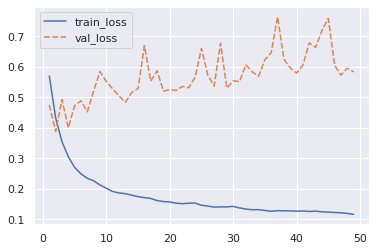

In [21]:
new_df = pd.DataFrame() 
#new_df['epoch'] = train_loss_df['epoch'] 
new_df['train_loss'] = train_loss_df['total_loss'] 
new_df['val_loss'] = val_loss_df['total_loss'] 

sns.lineplot(data = new_df[1:])
#new_df


# Calculate mAP on train set


In [53]:
importlib.reload(metrics)

<module 'src.metrics' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/metrics.py'>

In [54]:
num_classes = 7

#model setup 
model = get_instance_segmentation_model(num_classes)
model.to(device)

helper.load_model(model, 'model.pth')


Loaded from model model.pth!


In [55]:
train_loader = torch.utils.data.DataLoader(
 dataset_train, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())

In [56]:
#mAP but not calculated as per fed set since there's no negative set 
pred_boxes =[]
gt =[] 

for idx,X, y in train_loader:
    model.eval()
    y_pred = model(X.to(device)) 
    pred_boxes, gt = metrics.store_preds(idx, y, y_pred, pred_boxes, gt)

In [57]:
mAP_list = [] 
ap_list = []

thresholds= np.arange(0.5, 1, 0.05) #0.5 -0.95
for iou_thres in thresholds:
    mAP, AP = metrics.calculate_ap(pred_boxes, gt, iou_threshold = iou_thres,
                                         num_classes = len(val_data.class_idx_map))
    mAP_list.append(mAP) 
    ap_list.append(AP)

In [58]:
class_names = {} 
for key, val in train_data.class_idx_map.items() :
    for k, v in train_data.classes.items():
        if key == v:
            class_names[val] = k
print(class_names)
    

{1: 'cappuccino', 2: 'chessboard', 3: 'coffee_maker', 4: 'cowboy_hat', 5: 'drumstick', 6: 'monkey'}


## Average Precision

[Text(0.5, 1.0, 'Average Precision by IOU Threshold (train)')]

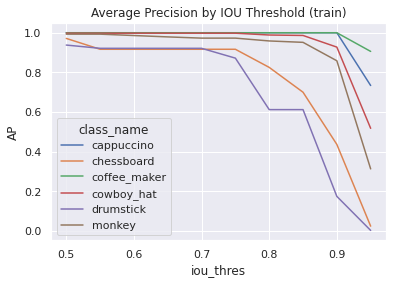

In [60]:
df_AP = pd.DataFrame(columns = ["iou_thres", "class_name", "AP"])

for idx, class_aps in enumerate(ap_list):
    iou_thres = thresholds[idx]
    for key, val in class_aps.items():
        class_name = class_names[key] 

        row = pd.DataFrame({"iou_thres": [iou_thres],
               "class_name": [class_name],
               "AP": [val.item()]
              })
        df_AP = pd.concat([df_AP, row], axis = 0, ignore_index = True)
        
df_AP.head()
sns.lineplot(data= df_AP, x="iou_thres", y="AP", hue = "class_name").set(title="Average Precision by IOU Threshold (train)")

## mean Average Precision 

[Text(0.5, 1.0, 'mAP (train)')]

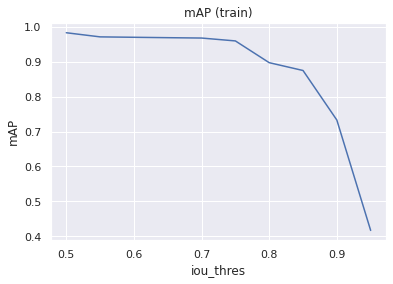

In [65]:
df_mAP = pd.DataFrame(columns = ["iou_thres", "mAP"])

for idx, mAP in enumerate(mAP_list):
    row = pd.DataFrame({"iou_thres":[thresholds[idx]],
                        "mAP": [mAP_list[idx].item()]})
    df_mAP = pd.concat([df_mAP, row], axis = 0, ignore_index = True) 
    
#df_mAP    
    
sns.lineplot(data = df_mAP, x ="iou_thres", y="mAP").set(title = "mAP (train)")

# Calculate mAP on test set

In [66]:
test_loader = torch.utils.data.DataLoader(
 val_data, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


In [67]:
pred_boxes =[]
gt =[] 

for idx,X, y in test_loader:
    model.eval()
    y_pred = model(X.to(device)) 
    pred_boxes, gt = metrics.store_preds(idx, y, y_pred, pred_boxes, gt)

In [69]:
mAP_list = [] 
ap_list = []

thresholds= np.arange(0.5, 1, 0.05) #0.5 -0.95
for iou_thres in thresholds:
    mAP, AP = metrics.calculate_ap(pred_boxes, gt, iou_threshold = iou_thres,
                                         num_classes = len(val_data.class_idx_map))
    mAP_list.append(mAP) 
    ap_list.append(AP)

In [70]:
class_names = {} 
for key, val in val_data.class_idx_map.items() :
    for k, v in val_data.classes.items():
        if key == v:
            class_names[val] = k
print(class_names)
    

{1: 'cappuccino', 2: 'chessboard', 3: 'coffee_maker', 4: 'cowboy_hat', 5: 'drumstick', 6: 'monkey'}


## calculate AP on train set

[Text(0.5, 1.0, 'Average Precision by IOU Threshold')]

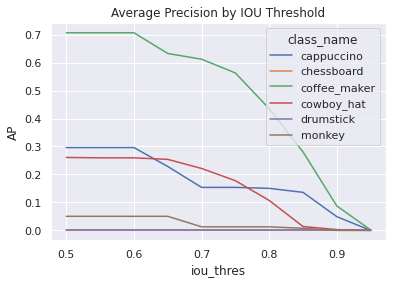

In [84]:
df_AP = pd.DataFrame(columns = ["iou_thres", "class_name", "AP"])

for idx, class_aps in enumerate(ap_list):
    iou_thres = thresholds[idx]
    for key, val in class_aps.items():
        class_name = class_names[key] 

        row = pd.DataFrame({"iou_thres": [iou_thres],
               "class_name": [class_name],
               "AP": [val.item()]
              })
        df_AP = pd.concat([df_AP, row], axis = 0, ignore_index = True)
        
df_AP.head()
sns.lineplot(data= df_AP, x="iou_thres", y="AP", hue = "class_name").set(title="Average Precision by IOU Threshold")

[Text(0.5, 1.0, 'Average Precision by IOU Threshold')]

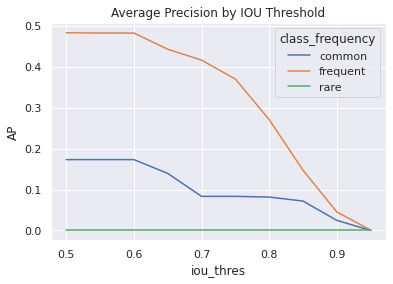

In [83]:
class_frequency_dict = {'cappuccino': 'common', 'chessboard': 'rare',  'coffee_maker':'frequent', 
                        'cowboy_hat':'frequent', 'drumstick':'rare', 'monkey':'common'}

df_AP_freq = df_AP
df_AP_freq['class_frequency'] = df_AP_freq['class_name'].map(class_frequency_dict)
temp = df_AP_freq.groupby(by= ["iou_thres", "class_frequency"])['AP'].mean().reset_index()
sns.lineplot(data= temp, x="iou_thres", y="AP", hue = "class_frequency").set(title="Average Precision by IOU Threshold")

## calculate mAP on train set

[Text(0.5, 1.0, 'mAP (test)')]

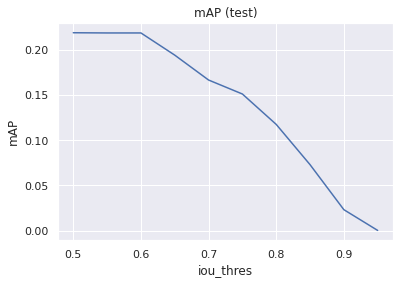

In [74]:
df_mAP = pd.DataFrame(columns = ["iou_thres", "mAP"])

for idx, mAP in enumerate(mAP_list):
    row = pd.DataFrame({"iou_thres":[thresholds[idx]],
                        "mAP": [mAP_list[idx].item()]})
    df_mAP = pd.concat([df_mAP, row], axis = 0, ignore_index = True) 
    
#df_mAP    
    
sns.lineplot(data = df_mAP, x ="iou_thres", y="mAP").set(title = "mAP (test)")

In [ ]:
for idx,X, y in test_loader:
